## Анализ данных в задаче кредитного скоринга

In [14]:
import pandas as pd
import numpy as np

import scipy
import math
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
import sklearn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

In [5]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [10]:
d1 = data.loc[(data['default'] == 1)].LIMIT_BAL

In [11]:
d2 = data.loc[(data['default'] == 0)].LIMIT_BAL

In [30]:
def proportions_confint_diff_ind(sample2, sample1, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * math.sqrt(abs(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2)))
    right_boundary = (p1 - p2) + z * math.sqrt(abs(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2)))
    
    return (left_boundary, right_boundary)

In [34]:
proportions_confint_diff_ind(d1, d2) # ответ к пункту а

(44115.18110053689, 51864.9582090081)

In [32]:
d1.mean()

130109.65641952984

In [33]:
d2.mean()

178099.72607430234

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [43]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

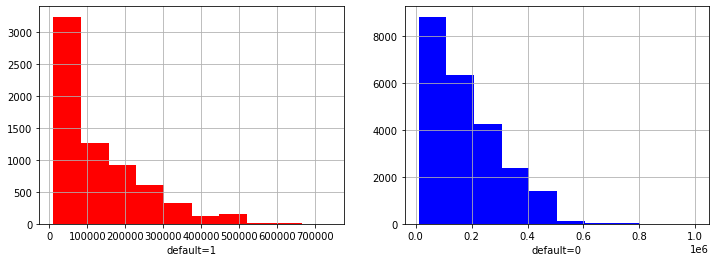

In [40]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(d1, color = 'r')
pylab.xlabel('default=1')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(d2, color = 'b')
pylab.xlabel('default=0')

pylab.show()
# странный рисунок, что с масштабом?????

Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [44]:
stats.mannwhitneyu(d1, d2)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

## Задание 2

Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [46]:
pay = data.loc[(data['default'] == 1)].SEX
no_pay = data.loc[(data['default'] == 0)].SEX

In [54]:
proportions_confint_diff_ind(pay, no_pay)

(0.021064699635331474, 0.07311831108919392)

In [55]:
stats.mannwhitneyu(pay, no_pay)

MannwhitneyuResult(statistic=73871136.0, pvalue=2.2382393460630904e-12)

In [58]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [61]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [67]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [68]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [69]:
print("p-value: %f" % permutation_test(pay, no_pay, max_permutations = 10000))

p-value: 0.000100


In [72]:
print("p-value: %f" % permutation_test(pay, no_pay, max_permutations = 500))

p-value: 0.002000


## Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  

In [73]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [ ]:
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                     columns=['product_name'], fill_value = 0)

In [74]:
new_df = data[['EDUCATION','default']]

In [76]:
new_df.head()

,EDUCATION,default
0,2,1
1,2,1
2,2,0
3,2,0
4,2,0


In [75]:
new_df.corr()

,EDUCATION,default
EDUCATION,1.000000,0.028006
default,0.028006,1.000000


In [114]:
sparse_sales = pd.pivot_table(data, values='default', index='ID',
                     columns=['EDUCATION'], fill_value = 0)

In [115]:
sparse_sales

EDUCATION,0,1,2,3,4,5,6
ID,,,,,,,
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
29996,0,0,0,0,0,0,0
29997,0,0,0,0,0,0,0
29998,0,0,1,0,0,0,0


In [116]:
sales_correlation = sparse_sales.corr()

In [117]:
sales_correlation.head()

EDUCATION,0,1,2,3,4,5,6
EDUCATION,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,-0.095345,-0.055957,-0.004122,-0.006611,-0.004407
2,NaN,-0.095345,1.000000,-0.073279,-0.005398,-0.008658,-0.005771
3,NaN,-0.055957,-0.073279,1.000000,-0.003168,-0.005081,-0.003387
4,NaN,-0.004122,-0.005398,-0.003168,1.000000,-0.000374,-0.000250


In [119]:
sales_correlation

EDUCATION,0,1,2,3,4,5,6
EDUCATION,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,-0.095345,-0.055957,-0.004122,-0.006611,-0.004407
2,NaN,-0.095345,1.000000,-0.073279,-0.005398,-0.008658,-0.005771
3,NaN,-0.055957,-0.073279,1.000000,-0.003168,-0.005081,-0.003387
4,NaN,-0.004122,-0.005398,-0.003168,1.000000,-0.000374,-0.000250
5,NaN,-0.006611,-0.008658,-0.005081,-0.000374,1.000000,-0.000400
6,NaN,-0.004407,-0.005771,-0.003387,-0.000250,-0.000400,1.000000


Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?